 1. Upload Your Files

In [2]:
from google.colab import files

uploaded = files.upload()


Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


2. Load & Merge the Data

In [8]:
import pandas as pd

movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

movies = movies.merge(credits, on='title')


 3. Basic Exploration

In [9]:
movies.head()
movies.info()
movies['genres'].value_counts().head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4809 non-null   int64  
 1   genres                4809 non-null   object 
 2   homepage              1713 non-null   object 
 3   id                    4809 non-null   int64  
 4   keywords              4809 non-null   object 
 5   original_language     4809 non-null   object 
 6   original_title        4809 non-null   object 
 7   overview              4806 non-null   object 
 8   popularity            4809 non-null   float64
 9   production_companies  4809 non-null   object 
 10  production_countries  4809 non-null   object 
 11  release_date          4808 non-null   object 
 12  revenue               4809 non-null   int64  
 13  runtime               4807 non-null   float64
 14  spoken_languages      4809 non-null   object 
 15  status               

,count
genres,
"[{""id"": 18, ""name"": ""Drama""}]",372
"[{""id"": 35, ""name"": ""Comedy""}]",282
"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",164
"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""name"": ""Romance""}]",144
"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""name"": ""Drama""}]",142
"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",109
"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""name"": ""Thriller""}]",88
"[{""id"": 99, ""name"": ""Documentary""}]",68
"[{""id"": 27, ""name"": ""Horror""}]",64


 4. Data Visualization

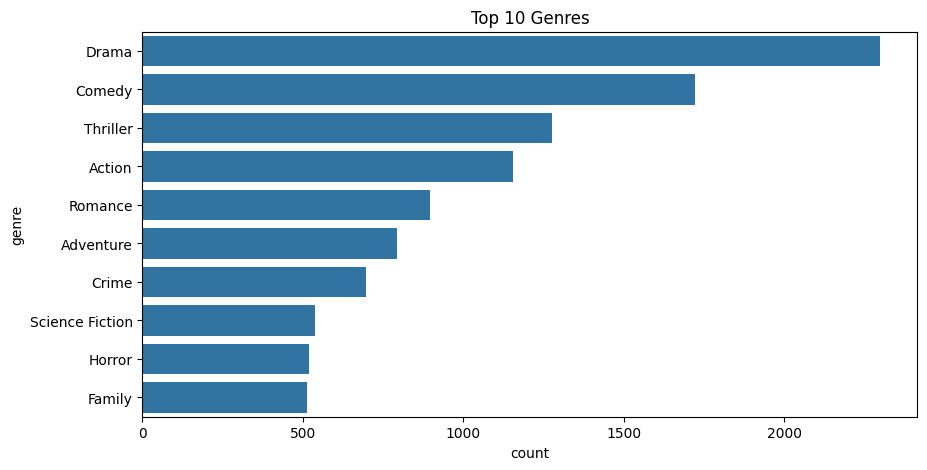

In [10]:
import ast
import matplotlib.pyplot as plt
import seaborn as sns


genre_list = []

for i in movies['genres']:
    for j in ast.literal_eval(i):
        genre_list.append(j['name'])


genre_df = pd.DataFrame(genre_list, columns=['genre'])

plt.figure(figsize=(10,5))
sns.countplot(data=genre_df, y='genre', order=genre_df['genre'].value_counts().index[:10])
plt.title('Top 10 Genres')
plt.show()


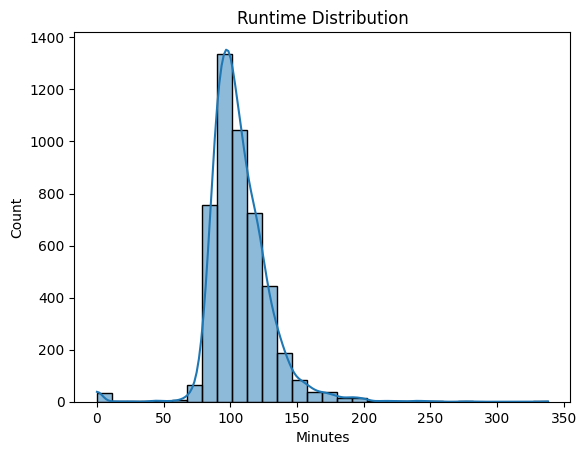

In [11]:
sns.histplot(movies['runtime'].dropna(), bins=30, kde=True)
plt.title('Runtime Distribution')
plt.xlabel('Minutes')
plt.show()


 5.WordCloud for Overviews or Keywords

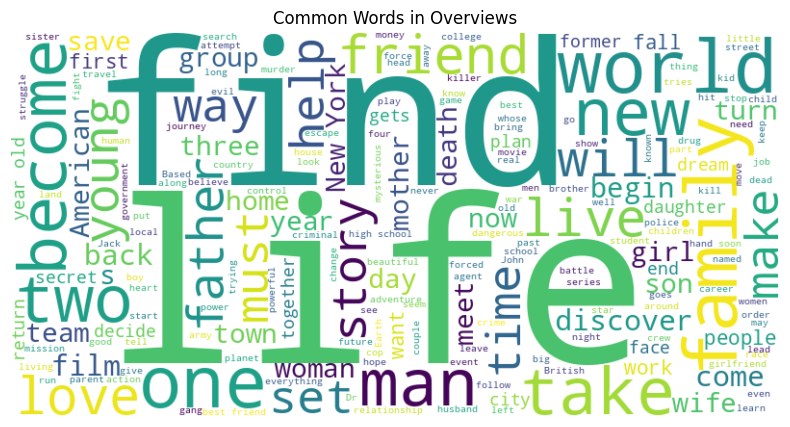

In [12]:
from wordcloud import WordCloud

text = ' '.join(movies['overview'].fillna(''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Overviews')
plt.show()


In [13]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')


movies = movies.merge(credits, on='title')


movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'tagline']]


movies['overview'] = movies['overview'].fillna('')
movies['tagline'] = movies['tagline'].fillna('')


def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L[:5]

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)


def get_cast(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L[:3]

movies['cast'] = movies['cast'].apply(get_cast)

def get_director(obj):
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            return [i['name']]
    return []

movies['crew'] = movies['crew'].apply(get_director)


movies['tags'] = movies['overview'] + ' ' + movies['tagline'] + ' ' + \
                 movies['genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['keywords'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['cast'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['crew'].apply(lambda x: ' '.join(x))


movies['tags'] = movies['tags'].apply(lambda x: x.lower().replace(" ", ""))


cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(movies['tags']).toarray()


similarity = cosine_similarity(vectors)


def get_recommendations(movie_title):
    idx = movies[movies['title'] == movie_title].index[0]
    distances = list(enumerate(similarity[idx]))
    sorted_movies = sorted(distances, key=lambda x: x[1], reverse=True)[1:11]
    return [movies.iloc[i[0]].title for i in sorted_movies]


print(get_recommendations("Battleship"))


['Step Up Revolution', 'The Transporter Refueled', 'A Very Harold & Kumar Christmas', 'Shanghai Knights', 'Sleepover', 'Fireproof', 'Robin Hood: Prince of Thieves', 'The Man from Snowy River', "The Brain That Wouldn't Die", 'High Tension']


Use this to save them:

In [14]:
# Save files in your notebook or script
import pickle

# Keep only the title column to save space
pickle.dump(movies[['title']], open('movies.pkl', 'wb'))
pickle.dump(similarity, open('similarity.pkl', 'wb'))
